![Save2Drive](https://raw.githubusercontent.com/alahnala/AI4All2020-Michigan-NLP/master/slides/save2drive.png)

# Run cell below to get setup

### Credit: NRC Emotion and Sentiment Lexicons
We are obtaining lexicons created by Saif Mohammed et al. See  [Sentiment and Emotion Lexicons](http://saifmohammad.com/WebPages/lexicons.html) and [Terms of Use](http://saifmohammad.com/WebPages/lexicons.html#terms)

In [1]:
import os, sys
import pandas as pd
IN_COLAB = 'google.colab' in sys.modules

print("=== Getting utils from git repo ===")
if IN_COLAB:
  !rm -r AI4All2020-Michigan-NLP
  !git clone https://github.com/alahnala/AI4All2020-Michigan-NLP.git
  !cp -r AI4All2020-Michigan-NLP/utils/ .
  !cp -r AI4All2020-Michigan-NLP/Data/ .
  !cp -r AI4All2020-Michigan-NLP/slides/ .
  !cp -r AI4All2020-Michigan-NLP/Experiment-Report-Templates/ .
  !echo "=== Files Copied ==="

# Helpers
print("=== Importing helper functions ===")
from nltk.stem.snowball import PorterStemmer
from utils.nlp_basics import *
from utils.syllable import *
from utils.sentiment_analysis_helpers import *
!python3 -m pip install wget
import wget 

# general
print("=== Importing helper functions ===")
from tqdm import tqdm
import regex as re
import pandas as pd
from collections import Counter
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
# Adding colors
# from matplotlib import cm
# cs=cm.Set1(np.arange(40)/40.)
matplotlib.rcParams.update({
    'font.family': 'serif',
})
plt.rcParams['font.size'] = 18
from collections import defaultdict

# preprocess functions
print("=== Importing natural language toolkit and spacy ===")
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
import spacy
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

# Download NRC lexicons
if not os.path.isfile(NRC_Emotion_Lexicon_Path):
    print("=== Downloading NRC Lexicons ===")
    !wget http://sentiment.nrc.ca/lexicons-for-research/NRC-Sentiment-Emotion-Lexicons.zip
    !unzip NRC-Sentiment-Emotion-Lexicons.zip
print("=== Loading NRC Lexicons to Dataframe ===")
SenseLevel_Emotion_Lexicon = load_senselevel_emotion_lexicon()
Color_Lexicon = load_colors()
print('=== Done ===')

=== Getting utils from git repo ===
=== Importing helper functions ===
=== Importing helper functions ===
=== Importing natural language toolkit and spacy ===


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/allielahnala/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


=== Loading NRC Lexicons to Dataframe ===
=== Done ===


# Emotion Lexicon

- During setup, we loaded the NRC Word-sense level emotion lexicon (created by Saif Mohammed)
- It contains a term, one to three synonyms for the term, and columns for the Affect categories (anger, fear, anticipation, trust, surprise, sadness, joy, and disgust) and for polarities (negative or positive)
- The affect and polarity columns indicate if the term has an association with affect category or polarity with **`True`** if so, and **`False`** if not
- ***Run the cell below to observe the data frame with the lexicon***

In [2]:
SenseLevel_Emotion_Lexicon

,term,Synonym 1,Synonym 2,Synonym 3,fear,anger,anticip,trust,surprise,positive,negative,sadness,disgust,joy
0,gut,opening,fistula,tubule,False,False,False,False,False,False,False,False,True,False
1,retraction,repentance,withdrawal,apostasy,False,False,False,False,False,False,False,False,False,False
2,conceit,vanity,assurance,airs,False,False,False,False,False,False,True,False,False,False
3,guide,teaching,direct,breed,False,False,False,True,False,True,False,False,False,False
4,foam,bubble,sparkle,mantle,False,False,False,False,False,False,False,False,False,False
5,uniform,clothing,outfit,harness,False,False,False,False,False,False,False,False,False,False
6,mouth,beginning,chops,lips,False,False,False,False,False,False,False,False,False,False
7,credit,approbation,kudos,popularity,False,False,False,False,False,False,False,False,False,False
8,associate,friend,colleague,neighbor,False,False,False,True,False,True,False,False,False,False
9,link,relation,tie,comparison,False,False,False,False,False,False,False,False,False,False


# Find out colors

In [3]:
Color_Lexicon

,term,Synonym 1,Synonym 2,Synonym 3,Color,% Votes
0,motive,motion,,,black,0.500000
1,saucepan,receptacle,,,grey,0.500000
2,merriment,cheerfulness,,,yellow,0.666667
3,saddle,support,,,brown,0.750000
4,coincide,identity,unaltered,one,grey,0.400000
5,coincide,identity,unaltered,one,pink,0.400000
6,assail,painfulness,,,red,0.545455
7,tableware,receptacle,,,white,0.400000
8,due,dueness,,,orange,0.500000
9,ditty,music,,,yellow,0.333333


In [4]:
get_term_rows('motive', Color_Lexicon)

,term,Synonym 1,Synonym 2,Synonym 3,Color,% Votes
0,motive,motion,,,black,0.5
7926,motive,motive,,,black,0.5
14121,motive,intention,,,red,0.6


# Create a message and process to tokens

In [5]:
message = "I'm good, how are you?"

def preprocess(message):
    tokens = word_tokenize(message.lower())
    return tokens

tokens = preprocess(message)
tokens

['i', "'m", 'good', ',', 'how', 'are', 'you', '?']

# Which words from our message are in the Lexicon?

In [6]:
# Get the set of terms in the lexicon
Lexicon_Terms = set(SenseLevel_Emotion_Lexicon['term'].values)

# Save the tokens list as a set in Tokens_Set
Tokens_Set = set(tokens)

# Show the intersection of these sets
Lexicon_Terms.intersection(Tokens_Set)

{'good'}

# Make 'pie slices' for Affects and Polarities

- We are going to make a pie chart to show the proportion of each affect and of each polarity in this message. 
- The cell below prints out the list of Affects and Polarities for demonstration, and the cell after that creates lists needed for making the pie charts.

In [7]:
print("Affects list:", Affects)
print("Polarities list:", Polarities)

Affects list: ['fear', 'anger', 'anticip', 'trust', 'surprise', 'sadness', 'disgust', 'joy']
Polarities list: ['positive', 'negative']


### What's happening in the cell below:
1. Initialize lists, one the sizes of `Affects` and one the size of `Polarities`
2. Iterate through tokens
    1. If token is not in SenseLevel_Emotion_Lexicon, continue to next token. Otherwise...
    2. Get the entries in the Lexicon for the token
    3. For each affect, we count the number of entries that are True for that term and affect
        1. We add the number of Trues to the affect_pie_slices list at the position of the same affect in the Affects list
    4. For each Polarity (negative, positive), we count the number of entries that are True for that term and polarity
        1. We add the number of Trues to the polarity_pie_slices list at the position of the same polarity in the Polarities list

In [8]:
# Initialize lists
affect_pie_slices = [0] * len(Affects)
polarity_pie_slices = [0] * len(Polarities)

# Iterate through each tokens
for token in tokens:
    
    # If token is not in SenseLevel_Emotion_Lexicon, continue to next token. Otherwise...
    if token in SenseLevel_Emotion_Lexicon['term'].values:
        
        # Get the entries in the Lexicon for the token
        term_rows = get_term_rows(token, SenseLevel_Emotion_Lexicon)
        
        # For each affect, we count the number of entries that are True for that term and affect
        for i, affect in enumerate(Affects):
            affect_counter = Counter(term_rows[affect].values)
            true_count = affect_counter[True]
            
            # We add the number of Trues to the affect_pie_slices list at the position of the same affect in the Affects list
            affect_pie_slices[i] += true_count
        
        # For each Polarity (negative, positive), we count the number of entries that are True for that term and polarity
        for i, pol in enumerate(Polarities):
            pol_counter = Counter(term_rows[pol].values)
            true_count = pol_counter[True]
            
            # We add the number of Trues to the polarity_pie_slices list at the position of the same polarity in the Polarities list
            polarity_pie_slices[i] += true_count

            
print('Affect Pie Slices:', affect_pie_slices)
print('Polarity Pie Slices:', polarity_pie_slices)            



Affect Pie Slices: [0, 0, 1, 2, 1, 0, 0, 2]
Polarity Pie Slices: [2, 0]


# Create our Pie Charts using the pie slices

The pie charts help us visualize the potential emotions in our text

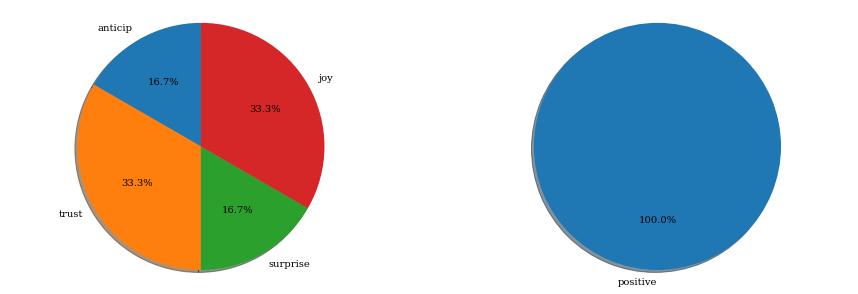

In [9]:
# Initialize Figure with 1 row and 2 columns of plots
fig, axs = plt.subplots(1, 2, figsize=(15, 5), sharey=False) 


# Make Pie Chart for Affects:
labels_1 = [affect for slice_, affect in zip(affect_pie_slices, Affects) if slice_ > 0]
sizes_1 = [slice_ for slice_, affect in zip(affect_pie_slices, Affects) if slice_ > 0]
axs[0].pie(sizes_1, labels=labels_1, autopct='%1.1f%%',
        shadow=True, startangle=90)
axs[0].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.


# Make Pie Chart for Polarities:
labels_2 = [affect for slice_, affect in zip(polarity_pie_slices, Polarities) if slice_ > 0]
sizes_2 = [slice_ for slice_, affect in zip(polarity_pie_slices, Polarities) if slice_ > 0]

axs[1].pie(sizes_2, labels=labels_2, autopct='%1.1f%%',
        shadow=True, startangle=90)
axs[1].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

# Get a larger sample of data

- Here we are obtaining text from two wikipedia pages, Gardening and Horticulture, to compare the Affects and Polarities

In [10]:
# get training data from same pages of more languages
import requests

pages = ['https://en.wikipedia.org/wiki/Gardening', 'https://en.wikipedia.org/wiki/Horticulture']
wikipedia_text = {}

for page in pages:
    title = page.split('/')[-1]
    prefix = page.split('/wiki/')[0]
    link = prefix + '/w/api.php'
    response = requests.get(link,params={'action': 'query','format': 'json','titles': title,'prop': 'extracts','explaintext': True,}).json()
    response_page = next(iter(response['query']['pages'].values()))
    text = response_page['extract']
    wikipedia_text[title] = text

print('Gardening:', wikipedia_text['Gardening'][:100], end='...\n')
print('Horticulture:', wikipedia_text['Horticulture'][:100], end='...\n')


Gardening: Gardening is the practice of growing and cultivating plants as part of horticulture. In gardens, orn...
Horticulture: Horticulture is the agriculture of plants, mainly for food, materials, comfort and beauty for decora...


# Make a Pie Chart for Gardening
- Refer to the steps we took above on our message "I'm good, how are you?" to create the pie charts for the Gardening text

In [11]:
Gardening_Text = wikipedia_text['Gardening']

def preprocess(message):
    tokens = word_tokenize(message.lower())
    return tokens

tokens = preprocess(Gardening_Text)

# Initialize lists
affect_pie_slices = [0] * len(Affects)
polarity_pie_slices = [0] * len(Polarities)

# Iterate through each tokens
for token in tokens:
    
    # If token is not in SenseLevel_Emotion_Lexicon, continue to next token. Otherwise...
    if token in SenseLevel_Emotion_Lexicon['term'].values:
        
        # Get the entries in the Lexicon for the token
        term_rows = get_term_rows(token, SenseLevel_Emotion_Lexicon)
        
        # For each affect, we count the number of entries that are True for that term and affect
        for i, affect in enumerate(Affects):
            affect_counter = Counter(term_rows[affect].values)
            true_count = affect_counter[True]
            
            # We add the number of Trues to the affect_pie_slices list at the position of the same affect in the Affects list
            affect_pie_slices[i] += true_count
        
        # For each Polarity (negative, positive), we count the number of entries that are True for that term and polarity
        for i, pol in enumerate(Polarities):
            pol_counter = Counter(term_rows[pol].values)
            true_count = pol_counter[True]
            
            # We add the number of Trues to the polarity_pie_slices list at the position of the same polarity in the Polarities list
            polarity_pie_slices[i] += true_count

            
print('Affect Pie Slices:', affect_pie_slices)
print('Polarity Pie Slices:', polarity_pie_slices)

Affect Pie Slices: [61, 56, 60, 92, 24, 49, 66, 144]
Polarity Pie Slices: [353, 142]


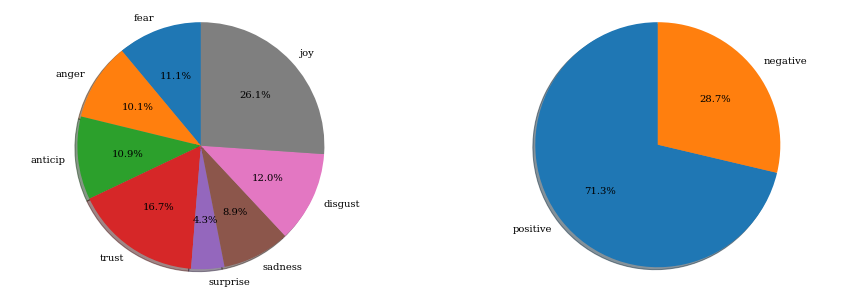

In [12]:
# Initialize Figure with 1 row and 2 columns of plots
fig, axs = plt.subplots(1, 2, figsize=(15, 5), sharey=False) 


# Make Pie Chart for Affects:
labels_1 = [affect for slice_, affect in zip(affect_pie_slices, Affects) if slice_ > 0]
sizes_1 = [slice_ for slice_, affect in zip(affect_pie_slices, Affects) if slice_ > 0]
axs[0].pie(sizes_1, labels=labels_1, autopct='%1.1f%%',
        shadow=True, startangle=90)
axs[0].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.


# Make Pie Chart for Polarities:
labels_2 = [affect for slice_, affect in zip(polarity_pie_slices, Polarities) if slice_ > 0]
sizes_2 = [slice_ for slice_, affect in zip(polarity_pie_slices, Polarities) if slice_ > 0]

axs[1].pie(sizes_2, labels=labels_2, autopct='%1.1f%%',
        shadow=True, startangle=90)
axs[1].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

# Make a Pie Chart for Horticulture
- Similarly, create the pie charts for the Horticulture text

In [13]:
Horticulture_Text = wikipedia_text['Horticulture']

def preprocess(message):
    tokens = word_tokenize(message.lower())
    return tokens

tokens = preprocess(Horticulture_Text)

# Initialize lists
affect_pie_slices = [0] * len(Affects)
polarity_pie_slices = [0] * len(Polarities)

# Iterate through each tokens
for token in tokens:
    
    # If token is not in SenseLevel_Emotion_Lexicon, continue to next token. Otherwise...
    if token in SenseLevel_Emotion_Lexicon['term'].values:
        
        # Get the entries in the Lexicon for the token
        term_rows = get_term_rows(token, SenseLevel_Emotion_Lexicon)
        
        # For each affect, we count the number of entries that are True for that term and affect
        for i, affect in enumerate(Affects):
            affect_counter = Counter(term_rows[affect].values)
            true_count = affect_counter[True]
            
            # We add the number of Trues to the affect_pie_slices list at the position of the same affect in the Affects list
            affect_pie_slices[i] += true_count
        
        # For each Polarity (negative, positive), we count the number of entries that are True for that term and polarity
        for i, pol in enumerate(Polarities):
            pol_counter = Counter(term_rows[pol].values)
            true_count = pol_counter[True]
            
            # We add the number of Trues to the polarity_pie_slices list at the position of the same polarity in the Polarities list
            polarity_pie_slices[i] += true_count

            
print('Affect Pie Slices:', affect_pie_slices)
print('Polarity Pie Slices:', polarity_pie_slices)


Affect Pie Slices: [4, 5, 35, 51, 8, 5, 5, 46]
Polarity Pie Slices: [140, 19]


In [ ]:
# Initialize Figure with 1 row and 2 columns of plots
fig, axs = plt.subplots(1, 2, figsize=(15, 5), sharey=False) 


# Make Pie Chart for Affects:
labels_1 = [affect for slice_, affect in zip(affect_pie_slices, Affects) if slice_ > 0]
sizes_1 = [slice_ for slice_, affect in zip(affect_pie_slices, Affects) if slice_ > 0]
axs[0].pie(sizes_1, labels=labels_1, autopct='%1.1f%%',
        shadow=True, startangle=90)
axs[0].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.


# Make Pie Chart for Polarities:
labels_2 = [affect for slice_, affect in zip(polarity_pie_slices, Polarities) if slice_ > 0]
sizes_2 = [slice_ for slice_, affect in zip(polarity_pie_slices, Polarities) if slice_ > 0]

axs[1].pie(sizes_2, labels=labels_2, autopct='%1.1f%%',
        shadow=True, startangle=90)
axs[1].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

# In the next few cells, we will practice making a rule-based Chatbot that responds to the emotions in a user's message

The code from Chatbot-Starter.ipynb is included - open in Colab for reference.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/alahnala/AI4All2020-Michigan-NLP/blob/master/Chatbot-Starter.ipynb)

### Walk through the code below to understand the `get_affects_and_polarities`

Run the cell and observe its output. Notice that the code is based off of the code we used earlier to generate the pie slices. Code often ends up coming in handy in multiple places!

In [ ]:
def preprocess(message):
    tokens = word_tokenize(message.lower())
    return tokens


def get_affects_and_polarities(message):

    # get message tokens
    tokens = preprocess(message)

    # Initialize dictionaries
    present_affects = {affect:0 for affect in Affects}
    present_polarities = {pol:0 for pol in Polarities}
    
    
    # Iterate through each tokens
    for token in tokens:

        # If token is not in SenseLevel_Emotion_Lexicon, continue to next token. Otherwise...
        if token in SenseLevel_Emotion_Lexicon['term'].values:

            # Get the entries in the Lexicon for the token
            term_rows = get_term_rows(token, SenseLevel_Emotion_Lexicon)

            # For each affect, we count the number of entries that are True for that term and affect
            for i, affect in enumerate(Affects):
                affect_counter = Counter(term_rows[affect].values)
                true_count = affect_counter[True]

                # We add the number of Trues to the value for the affect
                present_affects[affect] += true_count

            # For each Polarity (negative, positive), we count the number of entries that are True for that term and polarity
            for i, pol in enumerate(Polarities):
                pol_counter = Counter(term_rows[pol].values)
                true_count = pol_counter[True]

                # We add the number of Trues to the value for the polarity
                present_polarities[pol] += true_count
    
    return present_affects, present_polarities


# Output Example
test_positive = "Hello, I am feeling great today"
message_affects, message_polarities = get_affects_and_polarities(test_positive)
print("Test string:", test_positive, '\n', '-' * 40)
print("Affects:", message_affects)
print("Polarities:", message_polarities)
print("Positive Polarity:", message_polarities['positive'])


print()


test_negative = "Hello, I am feeling bad today"
message_affects, message_polarities = get_affects_and_polarities(test_negative)
print("Test string:", test_negative, '\n', '-' * 40)
print("Affects:", message_affects)
print("Polarities:", message_polarities)
print("Positive Polarity:", message_polarities['positive'])

![ChatBot](https://raw.githubusercontent.com/alahnala/AI4All2020-Michigan-NLP/master/slides/Chatbot-NewRule.png)

## Add some rules to the Chatbot Starter code so that the bot responds appropriately based on the user's emotions

This is where you can get creative! Here are some suggestions to get started:

1. Add a special response for when the user's message is more positive than negative -- this has been added already as an example, see the code under the NEW and NEW RULE comments
2. Add a special response for when the user's message is more negative than positive
3. Test out your rules with your own messages. Add new rules to account for situations that your observe.
4. Try making some responses that take the affects into account

In [ ]:
def get_input():
    
    user_message = input()
    return user_message

def get_bot_reply(user_message):
    
    Continue_Session = True
    
    # NEW
    message_affects, message_polarities = get_affects_and_polarities(user_message)
    
    # Make print statements like the one below to understand what's going on (remove # to use this one) 
    #print(message_polarities)
    
    bot_reply = 'No rule to handle this message yet.'
    
    if user_message.lower().strip() == 'quit':
        Continue_Session = False
        bot_reply = 'Thank you for chatting!'
        
    # NEW RULE
    elif message_polarities['positive'] > message_polarities['negative']:
        bot_reply = 'It sounds like things are going well, yes?'

    return bot_reply, Continue_Session

## Test out the example rule

Start the chatbot and respond with **"*Hello, I am feeling great today*"** to observe the bot's new response

In [ ]:
Continue_Session = True

Welcome_Message = 'Welcome to the chatbot! To quit, type "quit". How are you feeling today?'

print("Computer:", Welcome_Message)

while Continue_Session:
    print("Me:", end=' ', flush=True)
    user_message = get_input()
    bot_reply, Continue_Session = get_bot_reply(user_message)
    print("Computer:", bot_reply)

## Continue adding rules to your bot. Get creative!

Get creative with your bot, including changing the Welcome message. Have a friend, family member, or AI4All peer or instructor test it out.

Here are a couple of challenges to consider:
1. Can you make your bot respond with empathy for all of the emotions? 
2. Can you improve the way we determine the emotion and sentiment, rather just counting the sentiments?
3. Can you incorporate anything you learned from the previous parts of the NLP project to improve your bot?

# References the lexicons used are introduced in these papers below. These are also great resources to read to learn from!

NRC Emotion Intensity Lexicon: association of words with eight basic emotions (anger, anticipation, disgust, fear, joy, sadness, surprise, and trust). The lexicon with its fine-grained real-valued scores was created by manual annotation using Best--Worst Scaling. Available in over 100 different languages.
	Version: 1.0
	Number of terms: ~10,000 unigrams (words)
	Association scores: real-valued
	Creator: Saif M. Mohammad

	Papers:

	Saif M. Mohammad (2018). Word Affect Intensities. In Proceedings of the 11th edition of the Language Resources and Evaluation Conference, May 2018, Miyazaki, Japan.
    
    
NRC Emotion Lexicon: association of words with eight emotions (anger, fear, anticipation, trust, surprise, sadness, joy, and disgust) and two sentiments (negative and positive) manually annotated on Amazon's Mechanical Turk. Available in 105 different languages.
	Version: 0.92
	Number of terms: 14,182 unigrams (words), ~25,000 word senses
	Association scores: binary (associated or not)
	Creators: Saif M. Mohammad and Peter D. Turney

	Papers:

	Saif Mohammad and Peter Turney (2013). Crowdsourcing a Word-Emotion Association Lexicon. Computational Intelligence, 29 (3), 436-465, 2013.

	Saif Mohammad and Peter Turney (2010). Emotions Evoked by Common Words and Phrases: Using Mechanical Turk to Create an Emotion Lexicon, In Proceedings of the NAACL-HLT 2010 Workshop on Computational Approaches to Analysis and Generation of Emotion in Text, June 2010, LA, California.